In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import torch
import joblib
import numpy as np

# 自定义模块
from TransformerModel import TimeSeriesTransformer
from LSTMModel import TimeSeriesLSTM
from Blender import MLPBlender
from Util import create_sequences, sample_dataset, plot_metric, plot_multiple_curves, grid_search, safe_inverse_transform

# 其他库
from torch.utils.data import random_split, TensorDataset
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [3]:
# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# 准备数据，训练模型时会对train做k-fold。

# 准备train
df_train = pd.read_csv ('../TockFormerData\SPY_1hour_train.csv')
X, y, scaler, target_indices = create_sequences (df_train, seq_length=32, target_cols=['open', 'high', 'low', 'close'],
                                                 scale=True)
train_dataset = TensorDataset (X, y)
sample_dataset = sample_dataset (train_dataset, 0.1)

数据被缩放


In [5]:
# 准备test
df_test = pd.read_csv ('../TockFormerData\SPY_1hour_test.csv')
X_t, y_t, _, _ = create_sequences (df_test, seq_length=32, target_cols=['open', 'high', 'low', 'close'],
                                   scaler=scaler)
test_dataset = TensorDataset (X_t, y_t)

数据被缩放


In [6]:
# 准备val
df_val = pd.read_csv ('../TockFormerData\SPY_1hour_validate.csv')
X_val, y_val, _, _ = create_sequences (df_val, seq_length=32, target_cols=['open', 'high', 'low', 'close'],
                                       scaler=scaler)
val_dataset = TensorDataset (X_val, y_val)

数据被缩放


In [7]:
# 检查数据集大小
print (f"Train dataset size: {len(train_dataset)}")
print (f"Sample dataset size: {len(sample_dataset)}")
print (f"Test dataset size: {len(test_dataset)}")
print (f"Val dataset size: {len(val_dataset)}")

Train dataset size: 19639
Sample dataset size: 1963
Test dataset size: 231
Val dataset size: 29


In [ ]:
# 定义网格搜索 时序Transformer，找最好的超参数
# 固定的初始化参数
init_args = {
    'input_dim': 49,
    'output_dim': 4,
    'seq_length': 32,
    'dropout': 0.1
}

# 架构超参数空间
param_grid = {
    'model_dim': [64, 128],
    'num_heads': [2, 4],
    'num_layers': [2, 3]
}

best_params, best_score = grid_search (
    TimeSeriesTransformer,
    init_args,
    sample_dataset,
    param_grid,
    cv=3,
    scaler=scaler,
    target_indices=target_indices
)

print ('Best architecture:', best_params)
print ('Best avg CV MSE:', best_score)

In [8]:
# 应用最好的参数, 对全体数据进行 cv，检查performance
# best_params['input_dim'] = init_args['input_dim']
# best_params['output_dim'] = init_args['output_dim']
# best_params['seq_length'] = init_args['seq_length']
# best_params['dropout'] = init_args['dropout']

# 这里为了方便测试，直接使用预先调好的参数
best_params_tock = {
 'model_dim': 64,
 'num_heads': 4,
 'num_layers': 3,
 'input_dim': 49,
 'output_dim': 4,
 'seq_length': 32,
 'dropout': 0.1
 }


best_params_tock

{'model_dim': 64,
 'num_heads': 4,
 'num_layers': 3,
 'input_dim': 49,
 'output_dim': 4,
 'seq_length': 32,
 'dropout': 0.1}

In [ ]:
# 如果表现优异，对 tock 进行 train
tock = TimeSeriesTransformer (**best_params_tock)
train_loss, mse_list_train, r2_list_train = tock.train_model (
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    scaler=scaler,  # 回归任务需要 scaler 进行逆缩放
    target_indices=target_indices,  # 回归任务中目标列索引
    patience=10,
    log=True,
)

# 绘制训练结果
mse_list = np.array (mse_list_train)
r2_list = np.array (r2_list_train)
plot_metric (train_loss, y_label="loss", title="Train Loss", color='red')
plot_metric (mse_list[:, 3], y_label="mse", title="Val MSE", color='green')
plot_metric (r2_list[:, 3], y_label="r2", title="Val R²", color='blue')

Using device: cuda
Epoch 1: Bad batch threshold reached at batch 299. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 349. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 490. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 554. Reshuffling training data.
Epoch 1/50, Train Loss: 0.006703
Epoch 1/50, Val MSEs: [1300.854736328125, 1147.9896240234375, 1888.48583984375, 1758.5765380859375], R²: [-235.16888427734375, -225.07093811035156, -261.05963134765625, -366.85760498046875]
Epoch 2: Bad batch threshold reached at batch 157. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 207. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 257. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 441. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 491. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 541. Reshu

测试集 MSE:  [50.668087005615234, 31.703187942504883, 32.450347900390625, 25.401111602783203]
测试集 R²:  [-0.1786407232284546, 0.21790826320648193, 0.29619359970092773, 0.41095900535583496]


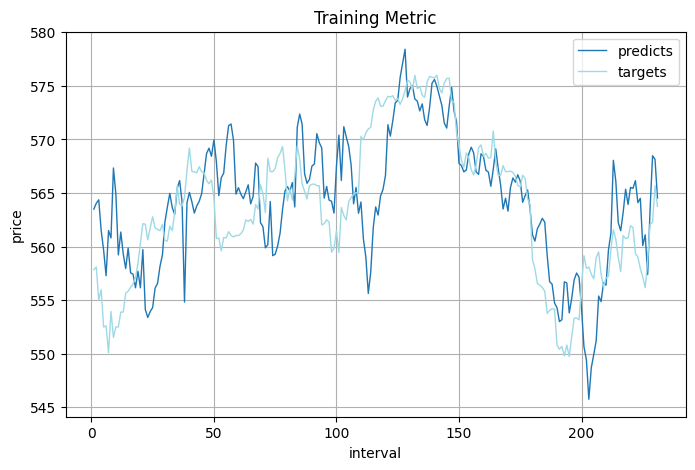

In [26]:
# 对test 进行测试
mse_list_tock, r2_list_tock, preds_tock, targets = tock.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)


print ("测试集 MSE: ", mse_list_tock)
print ("测试集 R²: ", r2_list_tock)

curve_dict = {}
curve_dict['predicts'] = preds_tock[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [ ]:
# 网格搜索 LSTM 超参数

init_args_lstm = {
    'input_dim': 49,
    'output_dim': 4,
    'seq_length': 32,
    'dropout': 0.1
}

param_grid_lstm = {
    'hidden_dim': [64, 128],
    'num_layers': [2, 3],
}

best_params_lstm, best_score_lstm = grid_search (
    TimeSeriesLSTM,
    init_args_lstm,
    sample_dataset,
    param_grid=param_grid_lstm,
    cv=3,
    scaler=scaler,
    target_indices=target_indices
)

print ('Best architecture:', best_params_lstm)
print ('Best avg CV MSE:', best_score_lstm)

In [15]:
# 应用最好的参数, 对全体数据进行 cv，检查performance
# best_params['input_dim'] = init_args['input_dim']
# best_params['output_dim'] = init_args['output_dim']
# best_params['seq_length'] = init_args['seq_length']
# best_params['dropout'] = init_args['dropout']

# 这里为了方便测试，直接使用预先调好的参数
best_params_lstm = {
 'hidden_dim': 64,
 'input_dim': 49,
 'output_dim': 4,
 'num_layers': 3,
 'dropout': 0.1
 }

best_params_lstm

{'hidden_dim': 64,
 'input_dim': 49,
 'output_dim': 4,
 'num_layers': 3,
 'dropout': 0.1}

Epoch 1: reshuffling after 379 bad batches
Epoch 1: reshuffling after 430 bad batches
Epoch 1: reshuffling after 480 bad batches
Epoch 1: reshuffling after 530 bad batches
Epoch 1: reshuffling after 580 bad batches
Epoch 1/50, Loss: 0.028119
Epoch 1/50, Val MSEs: [50.310367584228516, 129.9465789794922, 46.804168701171875, 52.19595718383789], R²: [-8.133796691894531, -24.590078353881836, -5.494876861572266, -9.91830825805664]
Epoch 2: reshuffling after 56 bad batches
Epoch 2: reshuffling after 106 bad batches
Epoch 2: reshuffling after 214 bad batches
Epoch 2: reshuffling after 264 bad batches
Epoch 2: reshuffling after 339 bad batches
Epoch 2: reshuffling after 389 bad batches
Epoch 2: reshuffling after 439 bad batches


Epoch 2: reshuffling after 519 bad batches
Epoch 2: reshuffling after 569 bad batches
Epoch 2/50, Loss: 0.000321
Epoch 2/50, Val MSEs: [140.62704467773438, 251.3651885986328, 131.94566345214844, 128.14089965820312], R²: [-24.530696868896484, -48.500762939453125, -17.309709548950195, -25.804410934448242]
Epoch 3: reshuffling after 68 bad batches
Epoch 3: reshuffling after 118 bad batches
Epoch 3: reshuffling after 205 bad batches
Epoch 3: reshuffling after 255 bad batches
Epoch 3: reshuffling after 305 bad batches
Epoch 3: reshuffling after 355 bad batches
Epoch 3: reshuffling after 405 bad batches
Epoch 3: reshuffling after 455 bad batches
Epoch 3: reshuffling after 505 bad batches
Epoch 3: reshuffling after 555 bad batches
Epoch 3: reshuffling after 612 bad batches
Epoch 3/50, Loss: 0.000237
Epoch 3/50, Val MSEs: [50.40287399291992, 91.07160186767578, 50.387508392333984, 43.1015739440918], R²: [-8.150590896606445, -16.934520721435547, -5.99212646484375, -8.015953063964844]
Epoch 4: re

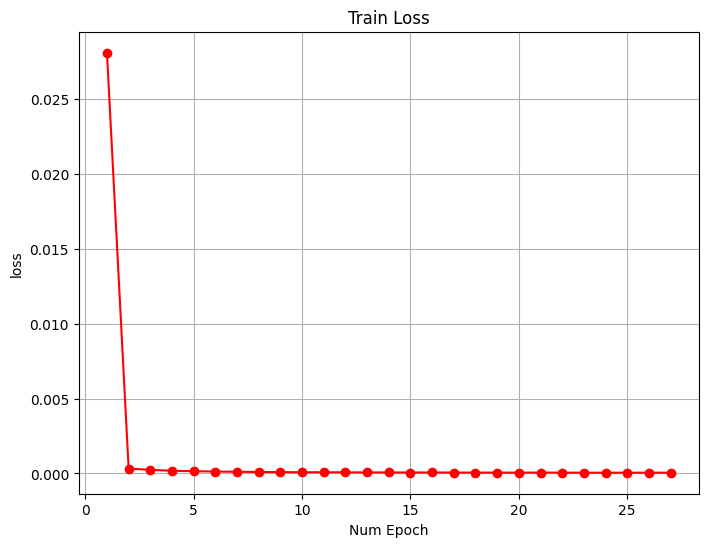

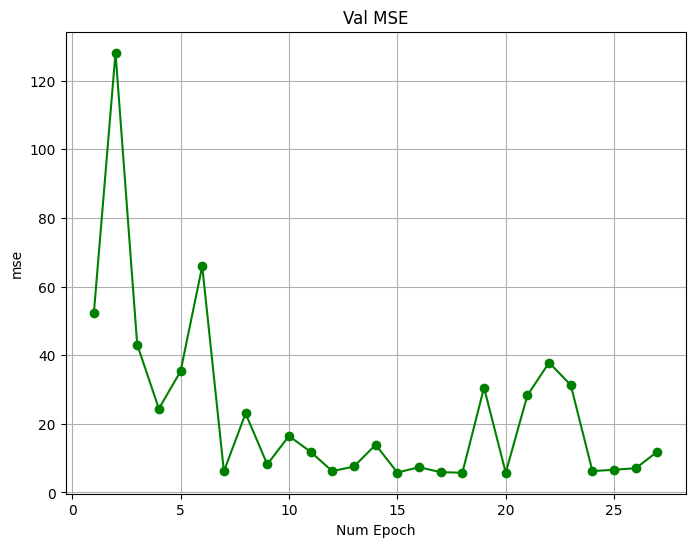

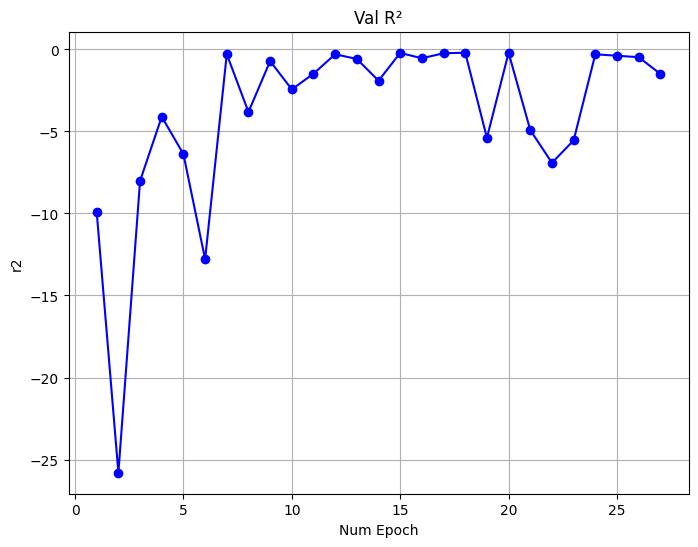

In [16]:
# 如果表现优异，对 lstm 进行 train
lstm = TimeSeriesLSTM (**best_params_lstm)
train_loss, mse_list_train, r2_list_train = lstm.train_model (
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    scaler=scaler,  # 回归任务需要 scaler 进行逆缩放
    target_indices=target_indices,  # 回归任务中目标列索引
    patience=10,
    log=True,
)

# 绘制训练结果
mse_list = np.array (mse_list_train)
r2_list = np.array (r2_list_train)
plot_metric (train_loss, y_label="loss", title="Train Loss", color='red')
plot_metric (mse_list[:, 3], y_label="mse", title="Val MSE", color='green')
plot_metric (r2_list[:, 3], y_label="r2", title="Val R²", color='blue')

测试集 MSE:  [10.325244903564453, 9.120044708251953, 15.676055908203125, 12.135936737060547]
测试集 R²:  [0.7598142027854919, 0.7750159502029419, 0.6600065231323242, 0.718572735786438]


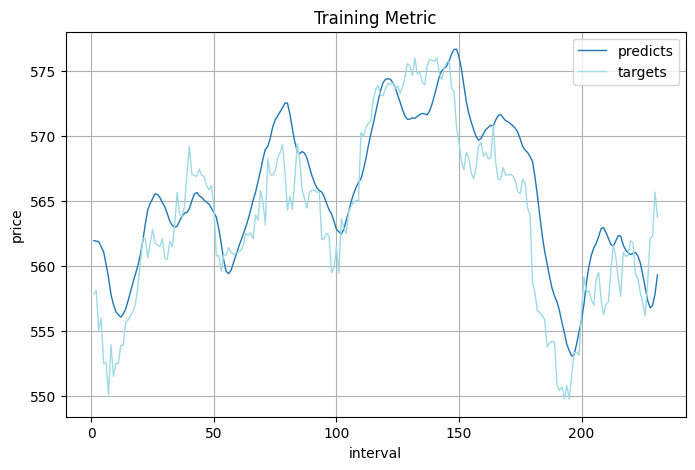

In [17]:
mse_list_lstm, r2_list_lstm, preds_lstm, targets = lstm.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)

print ("测试集 MSE: ", mse_list_lstm)
print ("测试集 R²: ", r2_list_lstm)

curve_dict = {}
curve_dict['predicts'] = preds_lstm[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [21]:
# 定义 blender 训练参数
# 
# （使用自定义blender，而不是sklearn，base在train上训练， blender在 val上训练 即 base 对val 的预测， 最后整体在 test 上测试）


blender_params = {
    'base_models': [tock, lstm],  # 基础模型列表
    'output_dim': 4,  # 4个目标值
    'hidden_dims': [32, 16],
    'dropout': 0.1,
}

blender = MLPBlender (**blender_params)

blender.fit (val_dataset, num_epochs=50, batch_size=32, lr=1e-4, log=True)

[MLPBlender] Epoch 1/50 – Loss 0.720682
[MLPBlender] Epoch 2/50 – Loss 0.725124
[MLPBlender] Epoch 3/50 – Loss 0.726476
[MLPBlender] Epoch 4/50 – Loss 0.715114
[MLPBlender] Epoch 5/50 – Loss 0.722206
[MLPBlender] Epoch 6/50 – Loss 0.704241
[MLPBlender] Epoch 7/50 – Loss 0.720398
[MLPBlender] Epoch 8/50 – Loss 0.702023
[MLPBlender] Epoch 9/50 – Loss 0.712774
[MLPBlender] Epoch 10/50 – Loss 0.715542
[MLPBlender] Epoch 11/50 – Loss 0.721375
[MLPBlender] Epoch 12/50 – Loss 0.707532
[MLPBlender] Epoch 13/50 – Loss 0.712299
[MLPBlender] Epoch 14/50 – Loss 0.715068
[MLPBlender] Epoch 15/50 – Loss 0.707372
[MLPBlender] Epoch 16/50 – Loss 0.703652
[MLPBlender] Epoch 17/50 – Loss 0.707760
[MLPBlender] Epoch 18/50 – Loss 0.711980
[MLPBlender] Epoch 19/50 – Loss 0.705631
[MLPBlender] Epoch 20/50 – Loss 0.688908
[MLPBlender] Epoch 21/50 – Loss 0.706387
[MLPBlender] Epoch 22/50 – Loss 0.703208
[MLPBlender] Epoch 23/50 – Loss 0.704456
[MLPBlender] Epoch 24/50 – Loss 0.699700
[MLPBlender] Epoch 25/50 

In [ ]:
weights = blender.get_model_importance ()
print ("Blender weights: ", weights)

In [24]:
preds_blender = blender.predict (test_dataset, batch_size=32)
preds_blender = safe_inverse_transform (preds_blender, scaler, target_indices)
preds_blender[:3]

array([[279.69574, 287.63385, 335.5886 , 205.78401],
       [279.69492, 287.6452 , 335.61353, 205.7704 ],
       [279.70364, 287.65237, 335.6521 , 205.75926]], dtype=float32)

In [25]:
preds_lstm[:3]

array([[561.8291 , 562.5708 , 561.5261 , 561.94946],
       [561.7904 , 562.53955, 561.50757, 561.9094 ],
       [561.7546 , 562.5081 , 561.47925, 561.8627 ]], dtype=float32)

In [27]:
preds_tock[:3]

array([[567.9868 , 565.319  , 564.2007 , 563.4999 ],
       [567.70636, 565.1664 , 564.07764, 564.0462 ],
       [568.0957 , 565.9125 , 564.32965, 564.3672 ]], dtype=float32)

In [ ]:
# 训练 residual module

from BiasCorrector import BiasCorrector
from sklearn.metrics import mean_squared_error, r2_score


x_tensor = val_dataset.tensors[0]  # 输入特征
y_tensor = val_dataset.tensors[1]  # 对应标签

y = tock.safe_inverse_transform(y_tensor.numpy(), scaler=scaler, target_indices=target_indices)

# 使用 base model 进行预测（注意需要 batch 预测，如果模型较大）
preds_val = tock.predict_model(x_tensor, scaler=scaler, bias_corrector=None, target_indices=target_indices)  # shape: (N, num_targets)


mlp_corrector = BiasCorrector(mode='mean', scale='None')
mlp_corrector.fit(preds_val, y)


In [ ]:
mse_list_cor, r2_list_cor, preds_cor, targets = tock.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices,
                                                                        bias_corrector=mlp_corrector)

print ("测试集 MSE: ", mse_list_cor)
print ("测试集 R²: ", r2_list_cor)

curve_dict = {}
curve_dict['predicts'] = preds_cor[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [ ]:
# 如果test表现优异，则保存
model_out = "./xxx/xxx/"
scaler_out = "./xxx/xxx/"

os.makedirs (os.path.dirname (model_out), exist_ok=True)
os.makedirs (os.path.dirname (scaler_out), exist_ok=True)

print ("=" * 10 + " 保存模型Essentials... " + "=" * 10)
torch.save (model.state_dict (), model_out)
joblib.dump (scaler, scaler_out)